## Illustration of good, bad and useless practices when collinearity is encountered

In [1]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
def vif_desmtx(desmtx):
    vif = pd.DataFrame()
    vif['VIF'] = [
        variance_inflation_factor(desmtx.values, i)
        for i in range(desmtx.shape[1])
    ]
    vif['features'] = desmtx.columns
    return vif

In [3]:
def est_vif_add_desmat_labels(desmat):
    vifs = vif_desmtx(desmat)
    vif_subset = (
        vifs[~vifs['features'].isin(['constant'])].set_index('features').T
    )
    design_labels_with_vif = {
        label: f'{label}\nVIF={vif:.1f}'
        for label, vif in zip(vif_subset.columns, vif_subset.values[0])
    }
    desmat_vif_labels = desmat.rename(columns=design_labels_with_vif)
    return desmat_vif_labels

In [4]:
def make_desplot_corplot(
    desmat_left, desmat_right, name_left, name_right, figure_path=None
):
    designs = {name_left: desmat_left, name_right: desmat_right}

    design_mats = {}
    cor_mats = {}
    for key, desmat in designs.items():
        design_mats[key] = est_vif_add_desmat_labels(desmat)
        cor_mats[key] = design_mats[key].drop(columns=['constant']).corr()

    fig, axes = plt.subplots(2, 2, figsize=(8, 10))

    for i, name in enumerate(designs.keys()):
        plot_design_matrix(design_mats[name], ax=axes[0, i])
        axes[0, i].set_title(name)
        sns.heatmap(
            cor_mats[name],
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            cbar=False,
            ax=axes[1, i],
            square=True,
        )
        axes[1, i].set_title('Correlation')
        axes[1, i].tick_params(axis='x', rotation=90)
        axes[1, i].tick_params(axis='y', rotation=0)
    plt.tight_layout()
    fig.align_titles()
    if figure_path:
        plt.savefig(figure_path)
    plt.show()

In [5]:
# def make_step_desplot(
#     desmat_left,
#     desmat_right,
#     name_left,
#     name_right,
#     frame_times_left,
#     frame_times_right,
#     figure_path=None,
#     conv=False,
# ):
#     designs = {name_left: desmat_left, name_right: desmat_right}
#     fig, axes = plt.subplots(1, 2, figsize=(6.2, 1.5))
#     for i, name in enumerate(designs.keys()):
#         columns = designs[name].drop(columns=['constant']).columns
#         for line_num, column in enumerate(columns):
#             if conv:
#                 axes[i].plot(
#                     frame_times_left,
#                     designs[name][column],
#                     label=column,
#                     linewidth=2,
#                 )
#             else:
#                 axes[i].step(
#                     frame_times_right,
#                     designs[name][column],
#                     label=column,
#                     linewidth=2,
#                 )
#         axes[i].set_xticks([])
#         axes[i].set_yticks([])
#         axes[i].set_xlabel('')
#         axes[i].set_ylabel('')
#         axes[i].set_title(name, fontsize=12)
#         # axes[i].legend(loc='upper center', ncol=2, fontsize=8)
#         axes[i].legend(loc='upper left', fontsize=8, frameon=False)
#         axes[i].set_ylim(axes[i].get_ylim()[0], axes[i].get_ylim()[1] + 0.5)
#     plt.tight_layout()
#     fig.align_titles()
#     if figure_path:
#         plt.savefig(figure_path, bbox_inches='tight')
#     plt.show()

def make_step_desplot(
    desmat_left,
    desmat_right,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_left,
    frame_times_right,
    figure_path=None,
    conv=False,
):
    designs = {name_left: desmat_left, name_right: desmat_right}
    subtitles = [subtitle_left, subtitle_right]
    fig, axes = plt.subplots(2,1, figsize=(3, 5.5))
    for i, name in enumerate(designs.keys()):
        frame_times_loop = frame_times_left if i == 0 else frame_times_right
        columns = designs[name].drop(columns=['constant']).columns
        for line_num, column in enumerate(columns):
            if conv:
                axes[i].plot(
                    frame_times_loop,
                    designs[name][column],
                    label=column,
                    linewidth=2,
                )
            else:
                axes[i].step(
                    frame_times_loop,
                    designs[name][column],
                    label=column,
                    linewidth=2,
                    where='post'
                )
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        #axes[i].set_title(name, fontsize=12)
        axes[i].set_title(name, fontsize=12, pad=18)
        axes[i].text(0.5, 1.02, subtitles[i], transform=axes[i].transAxes, fontsize=10, ha='center')
        #axes[i].set_title(name)
        #axes[i].text(0.5, 1.05, 'TEST', transform=axes[i].transAxes, fontsize=8, ha='center')
        # axes[i].legend(loc='upper center', ncol=2, fontsize=8)
        axes[i].legend(loc='upper left', fontsize=8, frameon=False)
        axes[i].set_ylim(axes[i].get_ylim()[0], axes[i].get_ylim()[1] + 0.5)
    plt.tight_layout()
    fig.align_titles()
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

In [6]:
from nilearn.glm import expression_to_contrast_vector


def est_contrast_vifs(desmat, contrasts):
    """
    IMPORTANT: This is only valid to use on design matrices where each regressor represents a condition vs baseline
     or if a parametrically modulated regressor is used the modulator must have more than 2 levels.  If it is a 2 level modulation,
     split the modulation into two regressors instead.

    Calculates VIF for contrasts based on the ratio of the contrast variance estimate using the
    true design to the variance estimate where between condition correaltions are set to 0
    desmat : pandas DataFrame, design matrix
    contrasts : dictionary of contrasts, key=contrast name,  using the desmat column names to express the contrasts
    returns: pandas DataFrame with VIFs for each contrast
    """
    desmat_copy = desmat.copy()
    # find location of constant regressor and remove those columns (not needed here)
    desmat_copy = desmat_copy.loc[
        :, (desmat_copy.nunique() > 1) | (desmat_copy.isnull().any())
    ]
    # Scaling stabilizes the matrix inversion
    nsamp = desmat_copy.shape[0]
    desmat_copy = (desmat_copy - desmat_copy.mean()) / (
        (nsamp - 1) ** 0.5 * desmat_copy.std()
    )
    vifs_contrasts = {}
    for contrast_name, contrast_string in contrasts.items():
        contrast_cvec = expression_to_contrast_vector(
            contrast_string, desmat_copy.columns
        )
        true_var_contrast = (
            contrast_cvec
            @ np.linalg.pinv(desmat_copy.transpose() @ desmat_copy)
            @ contrast_cvec.transpose()
        )
        # The folllowing is the "best case" scenario because the between condition regressor correlations are set to 0
        best_var_contrast = (
            contrast_cvec
            @ np.linalg.pinv(
                np.multiply(
                    desmat_copy.transpose() @ desmat_copy,
                    np.identity(desmat_copy.shape[1]),
                )
            )
            @ contrast_cvec.transpose()
        )
        vifs_contrasts[contrast_name] = true_var_contrast / best_var_contrast
    return vifs_contrasts

# I think I'll use what's below

In [7]:
def est_vif_add_desmat_labels_boldvif(desmat):
    vifs = vif_desmtx(desmat)
    vif_subset = (
        vifs[~vifs['features'].isin(['constant'])].set_index('features').T
    )
    design_labels_with_vif = {
        label: f'{label}\n $\\mathbf{{VIF={vif:.0f}}}$'
        for label, vif in zip(vif_subset.columns, vif_subset.values[0])
    }
    desmat_vif_labels = desmat.rename(columns=design_labels_with_vif)
    return desmat_vif_labels



def make_desplot(
    desmat_left, desmat_right, name_left, name_right, figure_path=None
):
    designs = {name_left: desmat_left, name_right: desmat_right}

    design_mats = {}
    for key, desmat in designs.items():
        design_mats[key] = est_vif_add_desmat_labels_boldvif(desmat)

    fig, axes = plt.subplots(1, 2, figsize=(7, 7.4))

    for i, name in enumerate(designs.keys()):
        plot_design_matrix(design_mats[name], ax=axes[i])

        axes[i].set_yticks([])
        axes[i].set_ylabel('', fontsize=12)
        axes[i].set_title(name, fontsize=21)
        #axes[i].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
        axes[i].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False, rotation=85, 
                            labelsize=21)
        # name = 'face'
        # vif = 10
        # test_labels = [f'{name}\n $\\mathbf{{VIF={vif}}}$', f'{name}\n $\\mathbf{{VIF={vif}}}$', f'{name}\n $\\mathbf{{VIF={vif}}}$']
        #test_labels = [f"face" "\n" r"$\mathbf{VIF=10}$", f"face" "\n" r"$\mathbf{VIF=10}$", f"face" "\n" r"$\mathbf{VIF=10}$"]
        #test_labels = ['$\\mathbf{10}$', '$\\mathbf{10}$', '$\\mathbf{10}$']
        #design_mats[name].columns
        axes[i].set_xticklabels(design_mats[name].columns, ha='center')
        #axes[i].set_xticklabels(ha='right')
        #axes[i].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False, rotation=-90, labelsize=15)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.05)
    fig.align_titles()
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

In [8]:
onset_max = 50
onsets_a = np.arange(5, onset_max, 5)
onset_b = onsets_a + 1

onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['face'] * len(onsets_a) + ['house'] * len(onset_b))
duration = np.ones_like(onsets)

trial_type_modulation = np.array(
    ['face-house'] * len(onsets) + ['trial'] * len(onsets)
)
duration_modulation = np.concatenate([duration, duration])
onsets_modulation = np.concatenate([onsets, onsets])
modulation = np.concatenate(
    [np.where(trial_type == 'face', 1, -1), np.ones(len(trial_type))]
)

events_a_b_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_a_b_modulation = pd.DataFrame(
    {
        'onset': onsets_modulation,
        'trial_type': trial_type_modulation,
        'duration': duration_modulation,
        'modulation': modulation,
    }
)
frame_times = np.arange(0, onset_max + 5, 1)
original_design_matrix = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model='spm', drift_model=None
)

original_design_matrix_neural = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model=None, drift_model=None
)

modulated_design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_modulation,
    hrf_model='spm',
    drift_model=None,
)

modulated_design_matrix_neural = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_modulation,
    hrf_model=None,
    drift_model=None,
)    



A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [9]:
print(original_design_matrix.corr())
print(original_design_matrix.transpose() @ original_design_matrix)

print(modulated_design_matrix.corr())
print(modulated_design_matrix.transpose() @ modulated_design_matrix)

              face     house  constant
face      1.000000  0.942524       NaN
house     0.942524  1.000000       NaN
constant       NaN       NaN       NaN
              face     house   constant
face      1.873289  1.852506   9.234138
house     1.852506  1.870000   9.176788
constant  9.234138  9.176788  55.000000
            face-house     trial  constant
face-house    1.000000 -0.071778       NaN
trial        -0.071778  1.000000       NaN
constant           NaN       NaN       NaN
            face-house      trial   constant
face-house    0.038277   0.003289   0.057350
trial         0.003289   7.448303  18.410925
constant      0.057350  18.410925  55.000000


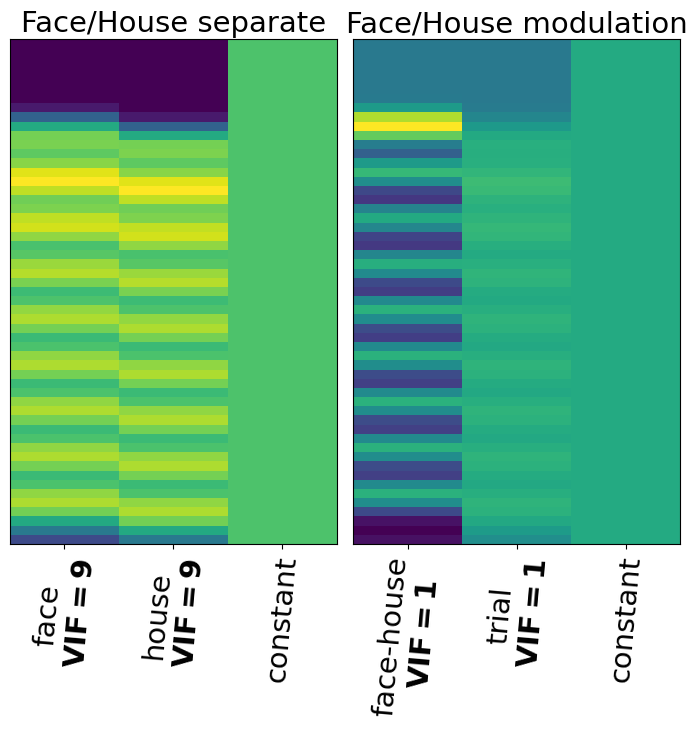

In [10]:
name_left = 'Face/House separate'
name_right = 'Face/House modulation'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/face_house_orth_des.pdf'
make_desplot(
    original_design_matrix,
    modulated_design_matrix,
    name_left,
    name_right,
    figure_path=figure_path,
)

## Redo as time course plots of neural signals

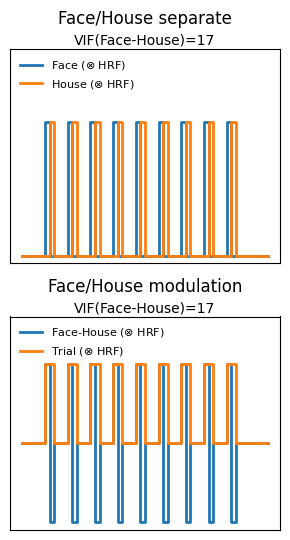

In [11]:
#\n VIF(Face-House)={vif_orig["Face-House"]:.0f}
original_design_matrix_neural_rename = original_design_matrix_neural.rename(columns={'face': r'Face ($\otimes$ HRF)', 'house': r'House ($\otimes$ HRF)'})

modulated_design_matrix_neural_rename = modulated_design_matrix_neural.rename(columns={'face-house': r'Face-House ($\otimes$ HRF)', 'trial': r'Trial ($\otimes$ HRF)'})

vif_orig = est_contrast_vifs(original_design_matrix, {'Face-House': 'face - house'})
vif_modulated = est_contrast_vifs(original_design_matrix, {'Face-House': 'face-house'})

name_left = f'Face/House separate'
subtitle_left = f'VIF(Face-House)={vif_orig["Face-House"]:.0f}'
name_right = f'Face/House modulation'
subtitle_right = f'VIF(Face-House)={vif_modulated["Face-House"]:.0f}'
fig_path = '/Users/jeanettemumford/Desktop/testfig.pdf'
make_step_desplot(
    original_design_matrix_neural_rename,
    modulated_design_matrix_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

## With/without derivative panel

In [12]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 2
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['face'] * len(onsets_a) + ['house'] * len(onset_b))
duration = np.ones_like(onsets)

events_a_b_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)

frame_times = np.arange(0, onset_max, 1)
des_with_deriv = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_separate,
    hrf_model='spm + derivative',
    drift_model=None,
)

des_no_deriv = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model='spm', drift_model=None
)

des_with_deriv_neural = make_first_level_design_matrix(
    frame_times,
    events=events_a_b_separate,
    hrf_model=None,
    drift_model=None,
)

des_no_deriv_neural = make_first_level_design_matrix(
    frame_times, events=events_a_b_separate, hrf_model=None, drift_model=None
)

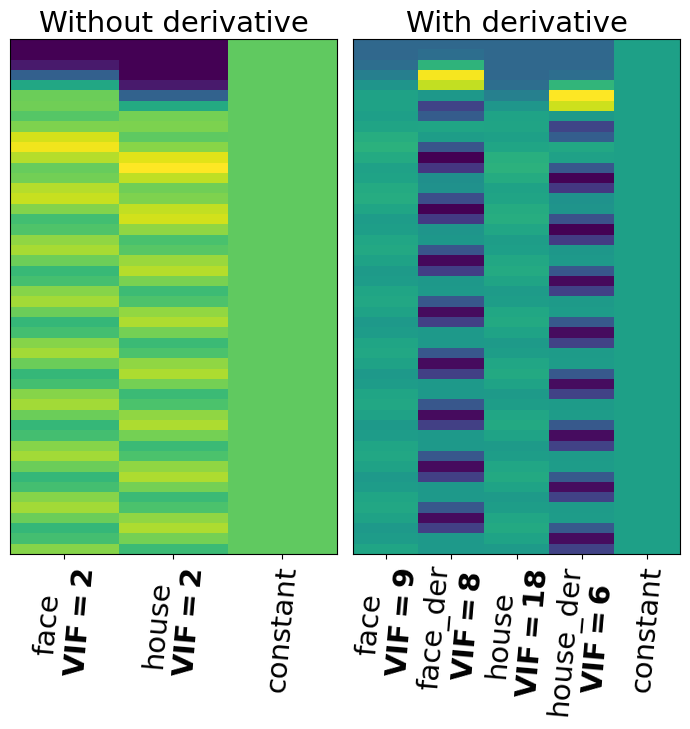

In [13]:
name_left = 'Without derivative'

name_right = 'With derivative'

des_with_deriv.columns = des_with_deriv.columns.str.replace(
    'derivative', 'der'
)

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/with_without_deriv_des.pdf'
make_desplot(
    des_no_deriv,
    des_with_deriv,
    name_left,
    name_right,
    figure_path=figure_path,
)

In [14]:
des_with_deriv_neural.columns

Index(['face', 'house', 'constant'], dtype='object')

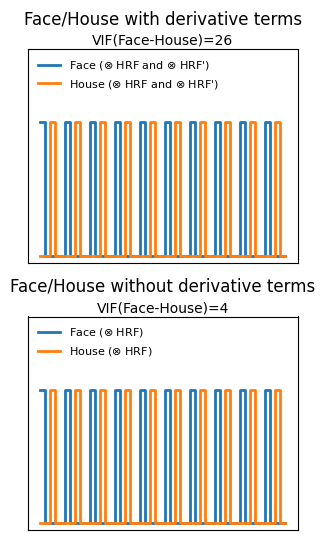

In [15]:
des_with_deriv_neural_rename = des_with_deriv_neural.rename(columns={'face': r"Face ($\otimes$ HRF and $\otimes$ HRF')", 'house': r"House ($\otimes$ HRF and $\otimes$ HRF')"})

des_no_deriv_neural_rename = des_no_deriv_neural.rename(columns={'face': r'Face ($\otimes$ HRF)', 'house': r'House ($\otimes$ HRF)'})

vif_deriv_yes = est_contrast_vifs(des_with_deriv, {'Face-House': 'face - house'})
vif_deriv_no = est_contrast_vifs(des_no_deriv, {'Face-House': 'face-house'})

name_left = f'Face/House with derivative terms'
subtitle_left = f'VIF(Face-House)={vif_deriv_yes["Face-House"]:.0f}'
name_right = f'Face/House without derivative terms'
subtitle_right = f'VIF(Face-House)={vif_deriv_no["Face-House"]:.0f}'
fig_path = '/Users/jeanettemumford/Desktop/testfig2.pdf'
make_step_desplot(
    des_with_deriv_neural_rename,
    des_no_deriv_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

In [16]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 0.5
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)
trial_type_cueprobe = np.array(['cue+probe'] * len(onsets_a))
duration_cue_probe = np.ones_like(onsets_a) * 2.5

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_cue_probe_together = pd.DataFrame(
    {
        'onset': onsets_a,
        'trial_type': trial_type_cueprobe,
        'duration': duration_cue_probe,
    }
)

frame_times = np.arange(0, onset_max, 1)
des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_cueprobe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_together,
    hrf_model='spm',
    drift_model=None,
)

des_cue_and_probe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model=None,
    drift_model=None,
)

des_cueprobe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_together,
    hrf_model=None,
    drift_model=None,
)

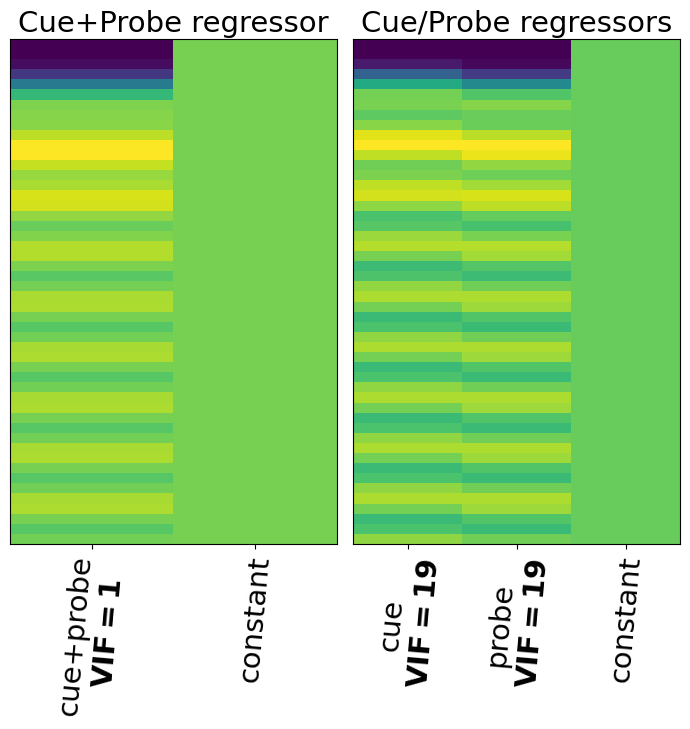

In [17]:
name_left = 'Cue+Probe regressor'
name_right = 'Cue/Probe regressors'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/cue_probe_combined_des.pdf'
make_desplot(
    des_cueprobe,
    des_cue_and_probe,
    name_left,
    name_right,
    figure_path=figure_path,
)

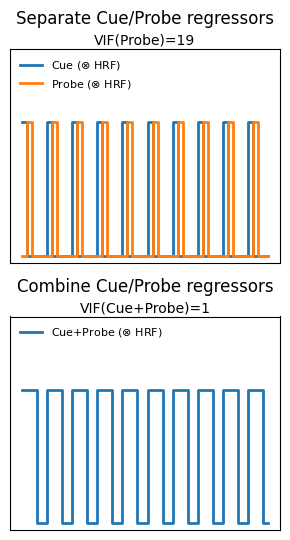

In [18]:
des_cue_and_probe_neural_rename = des_cue_and_probe_neural.rename(columns={'cue': r"Cue ($\otimes$ HRF)", 'probe': r"Probe ($\otimes$ HRF)"})

des_cueprobe_neural_rename = des_cueprobe_neural.rename(columns={'cue+probe': r'Cue+Probe ($\otimes$ HRF)'})

vif_cueprobe = est_contrast_vifs(des_cueprobe, {'cue+probe': 'cue+probe'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'Probe': 'probe'})

name_left = f'Separate Cue/Probe regressors'
subtitle_left = f'VIF(Probe)={vif_cue_and_probe["Probe"]:.0f}'
name_right = f'Combine Cue/Probe regressors'
subtitle_right = f'VIF(Cue+Probe)={vif_cueprobe["cue+probe"]:.0f}'
fig_path = '/Users/jeanettemumford/Desktop/testfig3.pdf'
make_step_desplot(
    des_cue_and_probe_neural_rename,
    des_cueprobe_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

## Using True durations

In [19]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 1.5
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)*1.5
duration_impulse = np.ones_like(onsets) * 0.0001
duration_impulse1 = np.ones_like(onsets)*.501

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_impulse = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration_impulse}
)

events_impulse1 = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration_impulse1}
)

frame_times = np.arange(0, onset_max, 1)
des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_impulse = make_first_level_design_matrix(
    frame_times, events=events_impulse, hrf_model='spm', drift_model=None
)


des_cue_and_probe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model=None,
    drift_model=None,
)

des_impulse_neural = make_first_level_design_matrix(
    frame_times, events=events_impulse1, hrf_model=None, drift_model=None
)

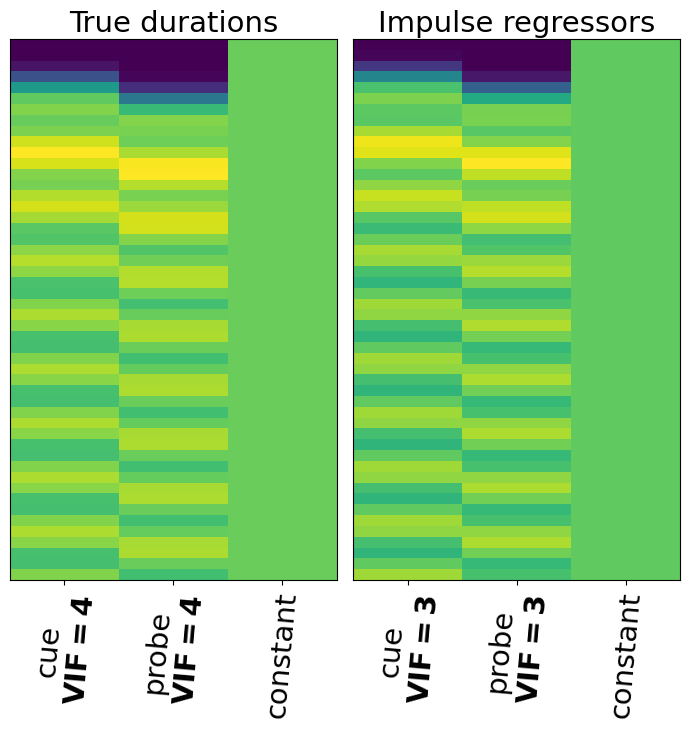

In [20]:
name_left = 'True durations'
name_right = 'Impulse regressors'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/impulse_des.pdf'
make_desplot(
    des_cue_and_probe,
    des_impulse,
    name_left,
    name_right,
    figure_path=figure_path,
)

In [21]:
def make_df_step(desmat, var_name1, var_name2):
    desmat = des_impulse_neural.copy()
    desmat['frame_times'] = frame_times

    rows = []
    for _, row in desmat.iterrows():
        rows.append(row)
        if row[var_name1] == 1 or row[var_name2] == 1:
            new_row = row.copy()
            new_row[var_name1] = 0
            new_row[var_name2] = 0
            rows.append(new_row)

    desmat_new = pd.DataFrame(rows).reset_index(drop=True)
    return desmat_new
   


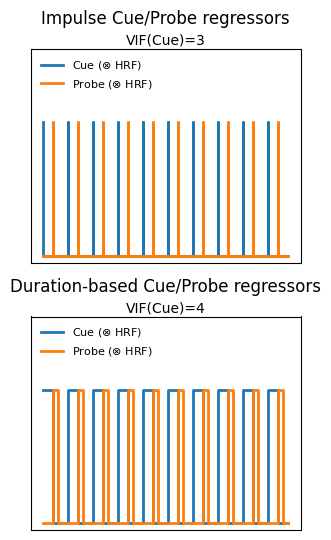

In [22]:
des_cue_and_probe_neural_rename = des_cue_and_probe_neural.rename(columns={'cue': r"Cue ($\otimes$ HRF)", 'probe': r"Probe ($\otimes$ HRF)"})

des_impulse_step = make_df_step(des_impulse_neural, 'cue', 'probe')
des_impulse_neural_rename = des_impulse_step.rename(columns={'cue': r"Cue ($\otimes$ HRF)", 'probe': r"Probe ($\otimes$ HRF)"})
frame_times_impulse = des_impulse_neural_rename['frame_times']
des_impulse_neural_rename = des_impulse_neural_rename.drop(columns=['frame_times'])

vif_impulse = est_contrast_vifs(des_impulse, {'cue': 'cue'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'cue': 'cue'})

name_left = f'Impulse Cue/Probe regressors'
subtitle_left = f'VIF(Cue)={vif_impulse["cue"]:.0f}'
name_right = f'Duration-based Cue/Probe regressors'
subtitle_right = f'VIF(Cue)={vif_cue_and_probe["cue"]:.0f}'
fig_path = '/Users/jeanettemumford/Desktop/testfig4.pdf'
make_step_desplot(
    des_impulse_neural_rename,
    des_cue_and_probe_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times_impulse,
    frame_times,
    figure_path=fig_path,
    conv=False,
)

## Omitting task regressors

In [23]:
onset_max = 50
onsets_a = np.arange(0, onset_max, 5)
onset_b = onsets_a + 0.7
onsets = np.concatenate([onsets_a, onset_b])
trial_type = np.array(['cue'] * len(onsets_a) + ['probe'] * len(onset_b))
duration = np.ones_like(onsets)
trial_type_cue = np.array(['cue'] * len(onsets_a))
duration_cue = np.ones_like(onsets_a) * 1

events_cue_probe_separate = pd.DataFrame(
    {'onset': onsets, 'trial_type': trial_type, 'duration': duration}
)
events_no_probe = pd.DataFrame(
    {
        'onset': onsets_a,
        'trial_type': trial_type_cue,
        'duration': duration_cue,
    }
)

frame_times = np.arange(0, onset_max, 1)
des_cue_and_probe = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model='spm',
    drift_model=None,
)

des_no_probe = make_first_level_design_matrix(
    frame_times, events=events_no_probe, hrf_model='spm', drift_model=None
)

des_cue_and_probe_neural = make_first_level_design_matrix(
    frame_times,
    events=events_cue_probe_separate,
    hrf_model=None,
    drift_model=None,
)

des_no_probe_neural = make_first_level_design_matrix(
    frame_times, events=events_no_probe, hrf_model=None, drift_model=None
)

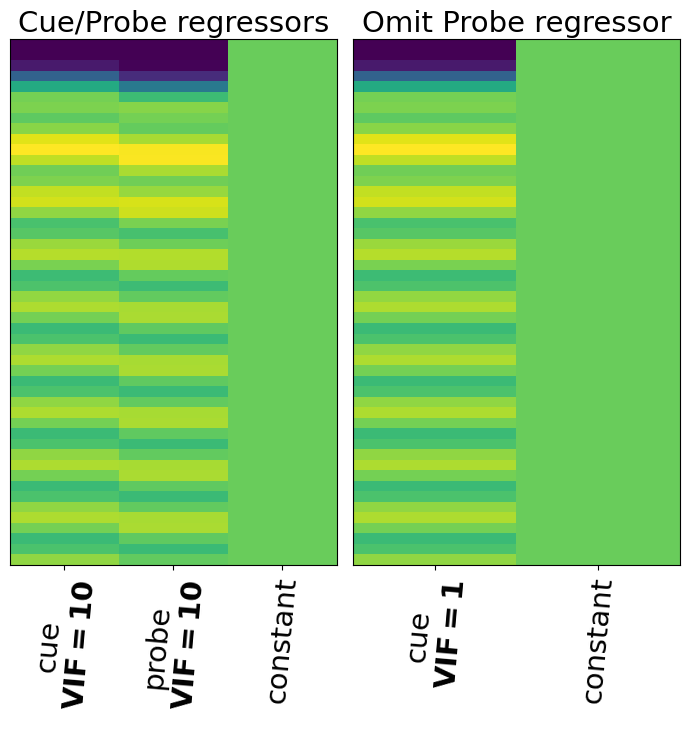

In [24]:
name_left = 'Cue/Probe regressors'
name_right = 'Omit Probe regressor'

figure_path = '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures/omit_probe_des.pdf'
make_desplot(
    des_cue_and_probe,
    des_no_probe,
    name_left,
    name_right,
    figure_path=figure_path,
)

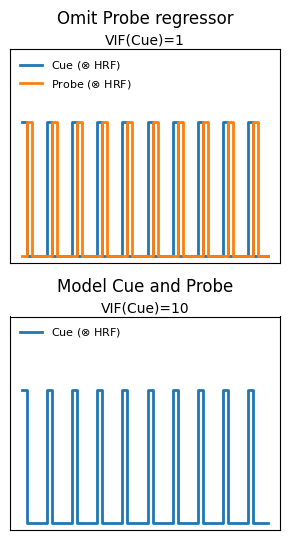

In [25]:
des_cue_and_probe_neural_rename = des_cue_and_probe_neural.rename(columns={'cue': r"Cue ($\otimes$ HRF)", 'probe': r"Probe ($\otimes$ HRF)"})

des_no_probe_neural_rename = des_no_probe_neural.rename(columns={'cue': r"Cue ($\otimes$ HRF)"})

vif_no_probe = est_contrast_vifs(des_no_probe, {'cue': 'cue'})
vif_cue_and_probe = est_contrast_vifs(des_cue_and_probe, {'cue': 'cue'})

name_left = f'Omit Probe regressor'
subtitle_left = f'VIF(Cue)={vif_no_probe["cue"]:.0f}'
name_right = f'Model Cue and Probe'
subtitle_right = f'VIF(Cue)={vif_cue_and_probe["cue"]:.0f}'
fig_path = '/Users/jeanettemumford/Desktop/testfig5.pdf'
make_step_desplot(
    des_cue_and_probe_neural_rename,
    des_no_probe_neural_rename,
    name_left,
    name_right,
    subtitle_left,
    subtitle_right,
    frame_times,
    frame_times,
    figure_path=fig_path,
    conv=False,
)